<a href="https://colab.research.google.com/github/AndyMDH/AndyMDH/blob/main/3D_Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCK506  End of Module: Investigating the Application of 3D Vision Transformers (ViT) for Alzheimer's Detection in T1-Weighted MRI Scans


## **Table of Contents**
## Table of Contents

1. [Setup and Dependencies](#1-setup-and-dependencies)
   - Environment Setup
   - Library Imports
   - Configuration

2. [Data Module](#2-data-module)
   - Dataset Class Implementation
   - Data Loading Pipeline
   - Train/Val/Test Split Creation

3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
   - Dataset Distribution
   - MRI Scan Visualization
   - Statistical Analysis
   - Sample Visualization

4. [Preprocessing Pipeline](#4-preprocessing-pipeline)
   - 2D/3D Transform Implementation
   - Data Augmentation
   - Normalization Techniques
   - Preprocessed Sample Visualization

5. [Model Architecture](#5-model-architecture)
   - 2D Vision Transformer
   - 3D Vision Transformer
   - Transfer Learning Implementation
   - Model Configuration

6. [Training Pipeline](#6-training-pipeline)
   - Training Loop Implementation
   - Loss Functions
   - Optimization Strategy
   - Learning Rate Scheduling

7. [Model Evaluation](#7-model-evaluation)
   - Performance Metrics
   - Confusion Matrices
   - ROC Curves
   - Statistical Analysis

8. [Interpretability Analysis](#8-interpretability-analysis)
   - Attention Map Visualization
   - Feature Importance Analysis
   - Error Analysis
   - Clinical Interpretation

9. [Advanced Analysis](#9-advanced-analysis)
   - Cross Validation Results
   - Model Robustness Testing
   - Performance Distribution Analysis
   - Statistical Significance Testing

10. [References](#10-references)

---
## **Introduction**


### **Import Dependencies**

In [24]:
!pip install torch torchvision monai tensorboard pandas scikit-learn transformers

In [25]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from monai.transforms import *
from monai.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.utils.data import random_split
from transformers import ViTModel
from tqdm.notebook import tqdm
from google.colab import drive
import warnings

# Warnings configuration
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [46]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

---
### **Download Alzheimer MRI Dataset**

The dataset can be downloaded here: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download)

**Load Dataset into DataFrame from Google Drive**

In [47]:
# Mount Google Drive and set paths
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/ADNI/raw'
OUTPUT_PATH = '/content/drive/MyDrive/ADNI/processed'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## **Data Module**

Implementation of data handling components including dataset class, data loaders, and data organization.


In [28]:
class ADNIDataset(Dataset):
    """
    Custom Dataset for ADNI MRI scans.

    Attributes:
        data_dir (str): Directory containing the MRI scans
        transform (callable): Preprocessing transformations
        samples (list): List of (image_path, label) tuples
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = self._load_data()

        # Log dataset statistics
        self._log_statistics()

    def _load_data(self):
        samples = []
        classes = ['AD', 'CN', 'MCI']

        for idx, cls in enumerate(classes):
            cls_path = os.path.join(self.data_dir, cls)
            if os.path.exists(cls_path):
                for file in os.listdir(cls_path):
                    if file.endswith('.nii.gz'):
                        samples.append({
                            'image': os.path.join(cls_path, file),
                            'label': idx
                        })
        return samples

    def _log_statistics(self):
        """Log dataset composition"""
        class_dist = {}
        for sample in self.samples:
            label = sample['label']
            class_dist[label] = class_dist.get(label, 0) + 1

        print("Dataset Statistics:")
        print(f"Total samples: {len(self.samples)}")
        print("Class distribution:", class_dist)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [29]:
def create_data_splits(dataset, train_ratio=0.7, val_ratio=0.15):
    """
    Create train/validation/test splits.

    Args:
        dataset: Complete dataset
        train_ratio: Proportion for training
        val_ratio: Proportion for validation

    Returns:
        train_dataset, val_dataset, test_dataset
    """
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Split sizes: Train={len(train_dataset)}, "
          f"Val={len(val_dataset)}, Test={len(test_dataset)}")

    return train_dataset, val_dataset, test_dataset

In [30]:
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=8):
    """
    Create DataLoader objects for training, validation and testing.

    Args:
        train_dataset, val_dataset, test_dataset: Dataset splits
        batch_size: Batch size for training

    Returns:
        train_loader, val_loader, test_loader
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=torch.cuda.is_available()
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=torch.cuda.is_available()
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=torch.cuda.is_available()
    )

    return train_loader, val_loader, test_loader

---
## **Exploratory Data Analysis**


In [31]:
def perform_dataset_analysis():
    """
    Analyze and visualize dataset characteristics.
    Returns basic statistics and class distribution.
    """
    classes = ['AD', 'CN', 'MCI']
    stats = {}

    for cls in classes:
        path = os.path.join(BASE_PATH, cls)
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.nii.gz')]
            stats[cls] = {
                'count': len(files),
                'sample_properties': []
            }

            # Analyze first 5 samples
            for file in files[:5]:
                img = nib.load(os.path.join(path, file))
                data = img.get_fdata()
                stats[cls]['sample_properties'].append({
                    'shape': data.shape,
                    'voxel_size': img.header.get_zooms(),
                    'intensity_range': (data.min(), data.max()),
                    'mean_intensity': data.mean(),
                    'std_intensity': data.std()
                })

    return pd.DataFrame(stats)

def visualize_dataset_distribution(stats_df):
    """
    Create visualization of dataset distribution and properties.
    """
    plt.figure(figsize=(15, 5))

    # Class distribution
    plt.subplot(131)
    counts = [stats_df[cls]['count'] for cls in stats_df.columns]
    plt.bar(stats_df.columns, counts)
    plt.title('Sample Distribution')
    plt.ylabel('Number of Samples')

    # Mean intensity distribution
    plt.subplot(132)
    for cls in stats_df.columns:
        intensities = [prop['mean_intensity']
                      for prop in stats_df[cls]['sample_properties']]
        plt.boxplot(intensities, positions=[list(stats_df.columns).index(cls)],
                   labels=[cls])
    plt.title('Intensity Distribution')

    plt.tight_layout()
    plt.show()

In [48]:
perform_dataset_analysis()

,AD,CN,MCI
count,0,0,0
sample_properties,[],[],[]


In [32]:
def visualize_mri_samples(n_samples=2):
    """
    Visualize sample MRI scans from each class in multiple views.
    """
    classes = ['AD', 'CN', 'MCI']

    for cls in classes:
        path = os.path.join(BASE_PATH, cls)
        files = [f for f in os.listdir(path) if f.endswith('.nii.gz')][:n_samples]

        fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
        fig.suptitle(f'{cls} MRI Samples', fontsize=16)

        for i, file in enumerate(files):
            img = nib.load(os.path.join(path, file))
            data = img.get_fdata()

            # Get middle slices
            x, y, z = [s//2 for s in data.shape]

            # Display three views
            views = [
                (data[x, :, :], 'Sagittal'),
                (data[:, y, :], 'Coronal'),
                (data[:, :, z], 'Axial')
            ]

            for j, (slice_data, title) in enumerate(views):
                axes[i, j].imshow(slice_data, cmap='gray')
                axes[i, j].set_title(f'{title} View')
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.show()

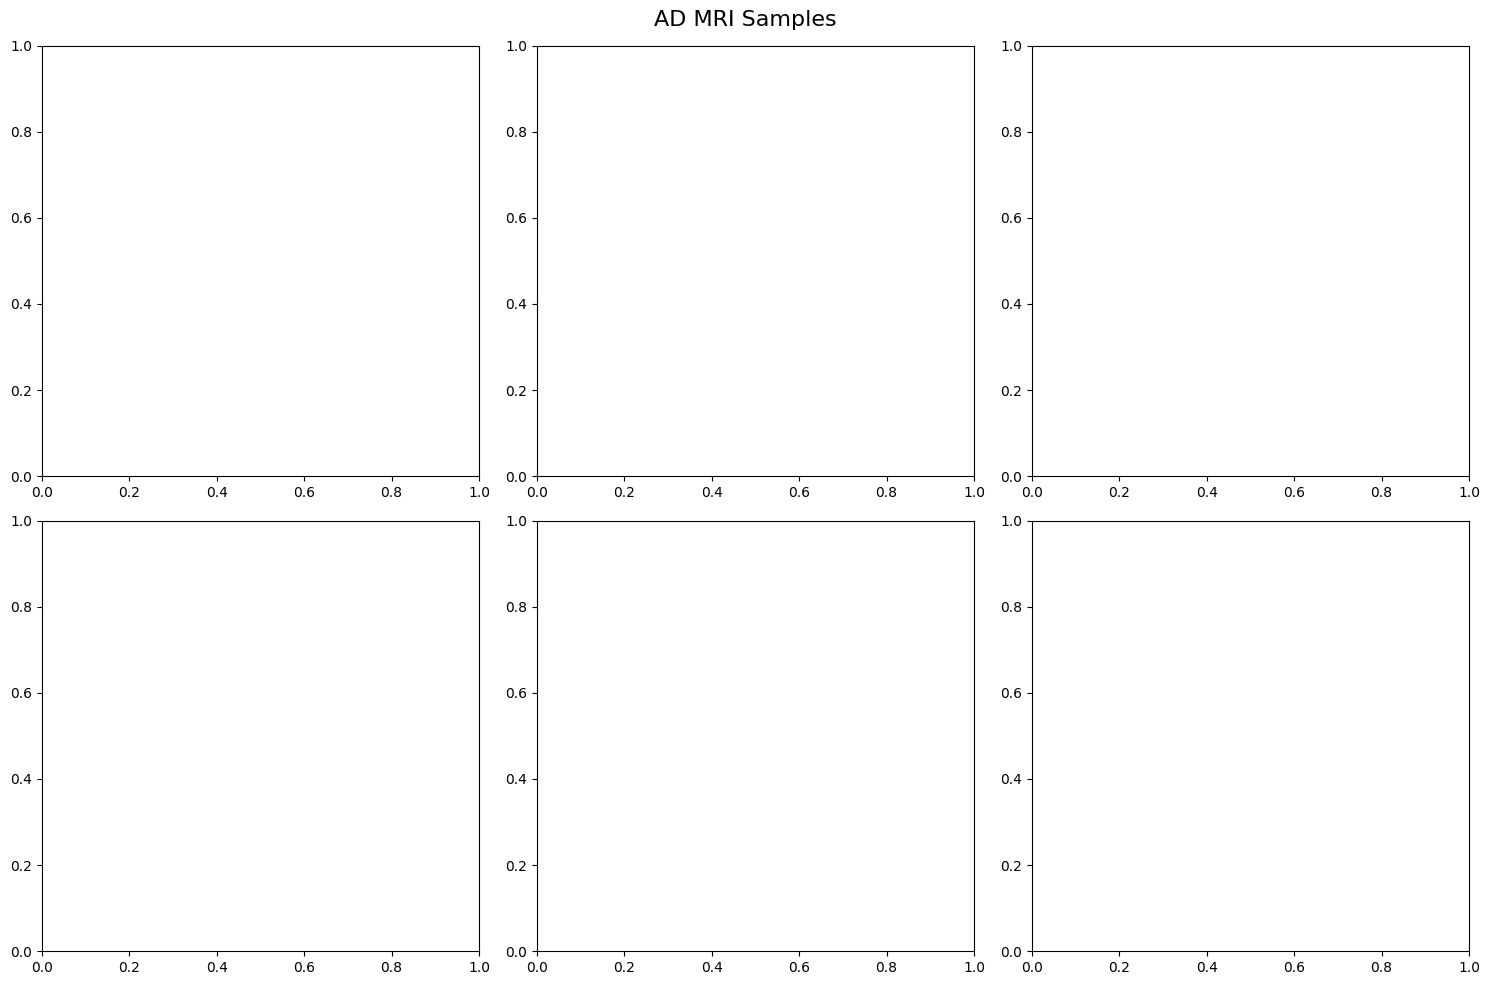

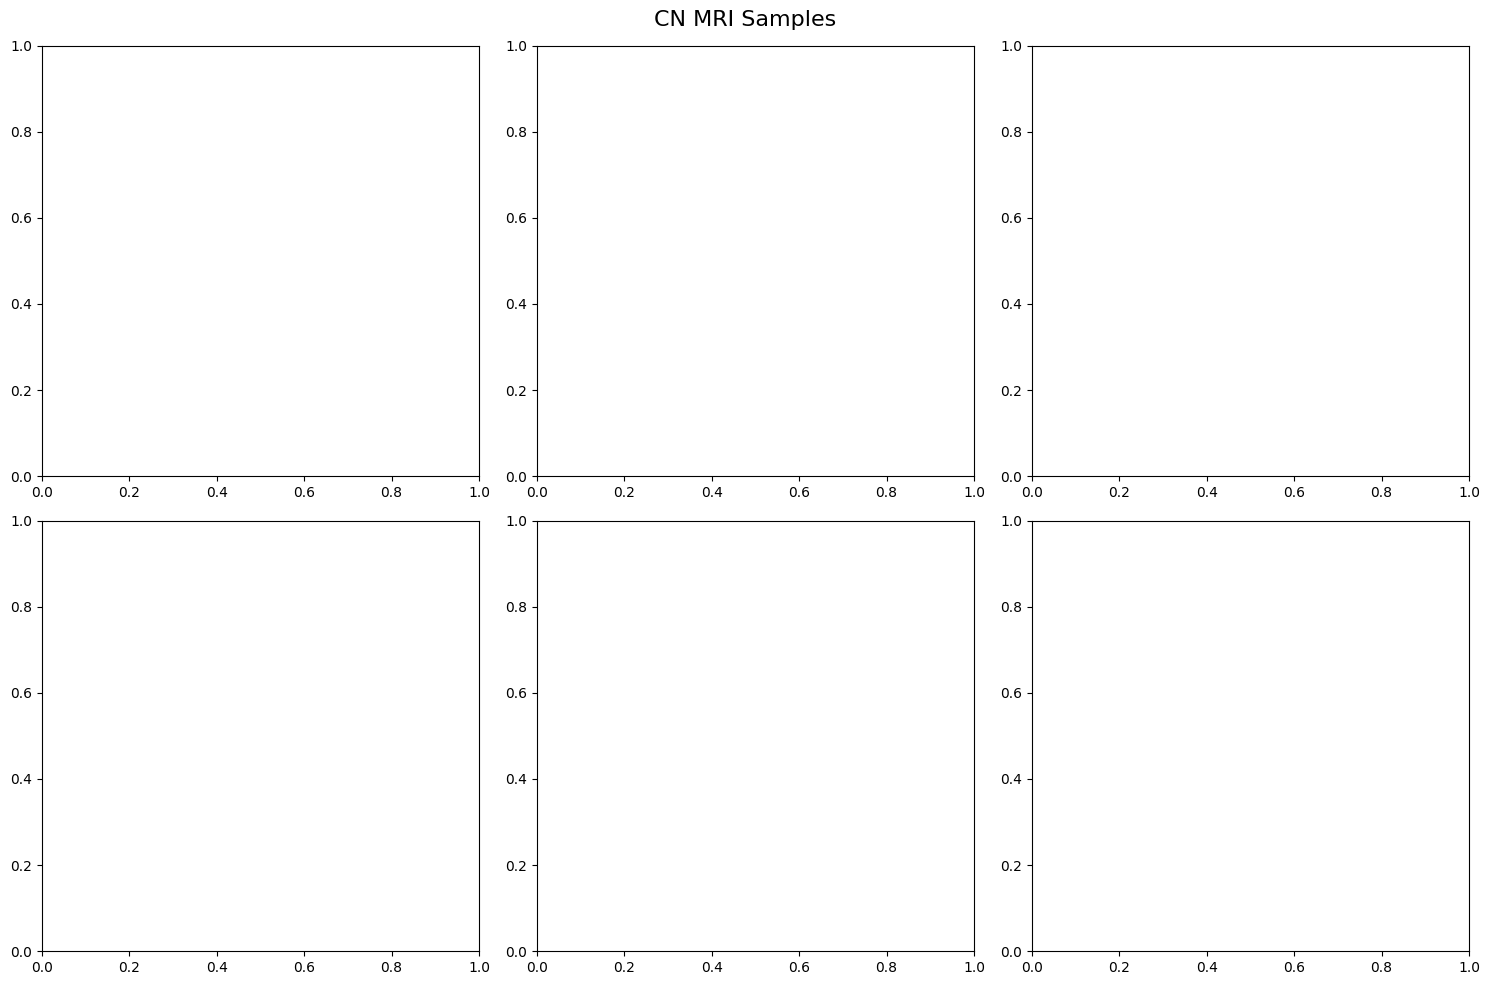

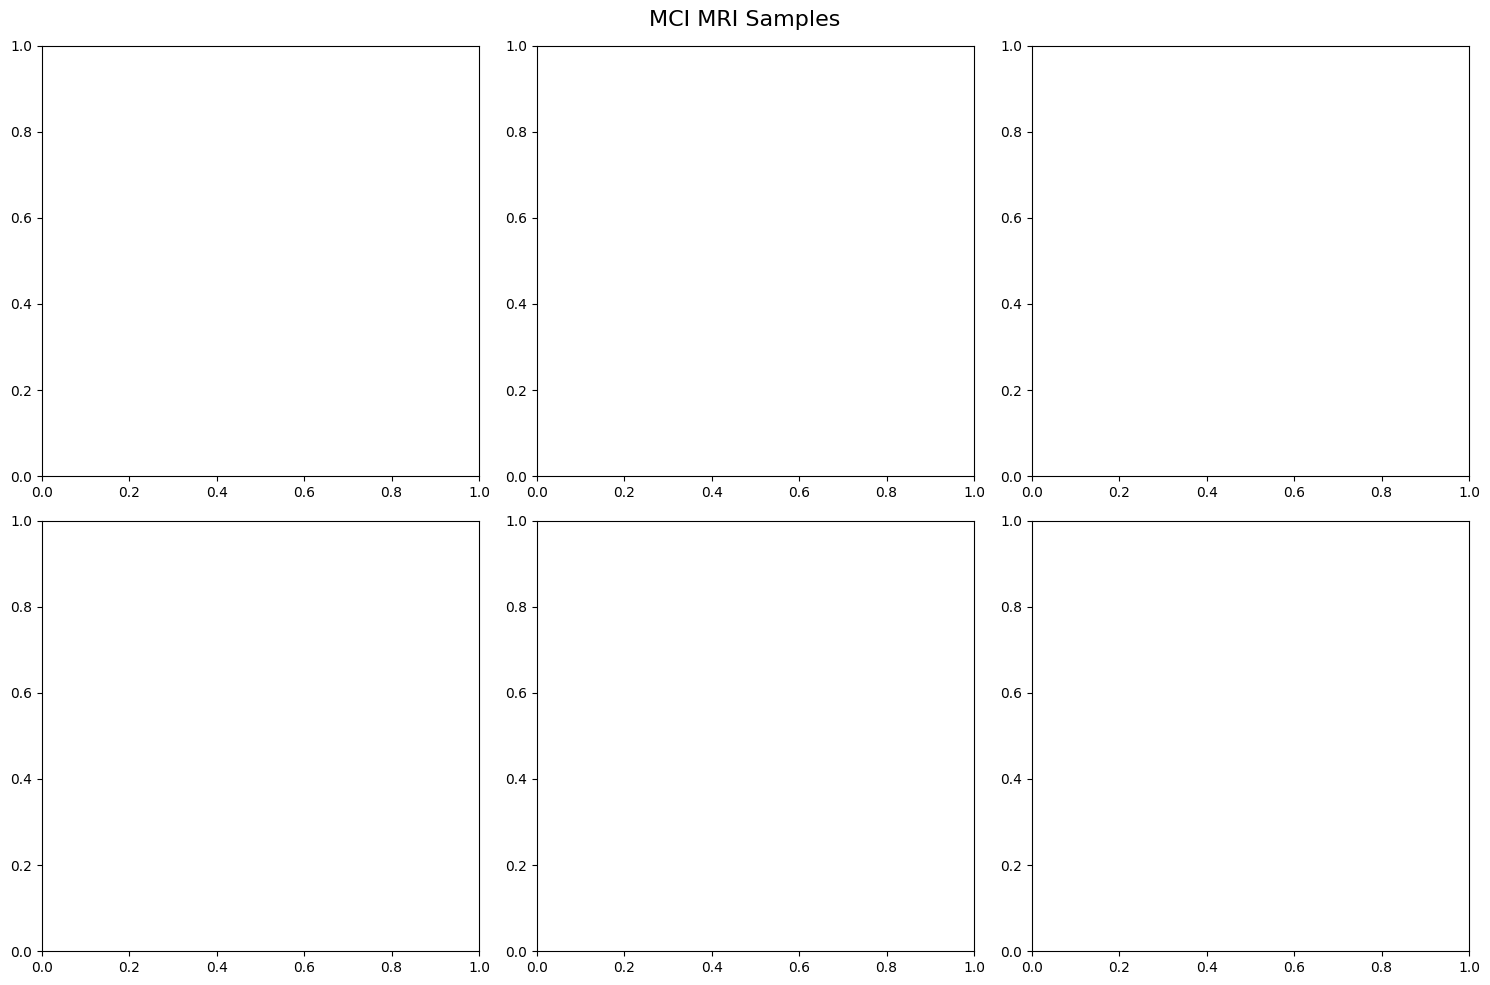

In [50]:
visualize_mri_samples()

Preprocessing Pipelines


In [33]:
class MRIPreprocessor:
    """
    Preprocessing pipeline for MRI scans.
    Supports both 2D and 3D preprocessing approaches.
    """
    def __init__(self, mode='2d', target_size=224):
        self.mode = mode
        self.target_size = target_size

    def get_transforms(self, phase="train"):
        """Create preprocessing pipeline"""
        common_transforms = [
            LoadImaged(keys=["image"]),
            EnsureChannelFirstd(keys=["image"]),
            Orientationd(keys=["image"], axcodes="RAS"),
            Spacingd(
                keys=["image"],
                pixdim=(1.5, 1.5, 1.5),
                mode="bilinear"
            ),
            CropForegroundd(
                keys=["image"],
                source_key="image",
                margin=10
            ),
            NormalizeIntensityd(
                keys=["image"],
                nonzero=True,
                channel_wise=True
            )
        ]

        # Mode-specific transforms
        if self.mode == '2d':
            common_transforms.extend([
                lambda x: {"image": x["image"][:, x["image"].shape[1]//2, :, :]},
                Resized(
                    keys=["image"],
                    spatial_size=(self.target_size, self.target_size)
                )
            ])
        else:
            common_transforms.append(
                Resized(
                    keys=["image"],
                    spatial_size=(self.target_size, self.target_size, self.target_size)
                )
            )

        # Training augmentations
        if phase == "train":
            common_transforms.extend([
                RandRotate90d(
                    keys=["image"],
                    prob=0.5,
                    spatial_axes=[0, 1] if self.mode == '2d' else [0, 1, 2]
                ),
                RandFlipd(
                    keys=["image"],
                    spatial_axis=0,
                    prob=0.5
                ),
                RandAffined(
                    keys=["image"],
                    prob=0.5,
                    rotate_range=0.2,
                    scale_range=0.1
                )
            ])

        return Compose(common_transforms)

def visualize_preprocessed_samples(dataset, n_samples=3):
    """
    Visualize samples after preprocessing.
    """
    loader = DataLoader(dataset, batch_size=n_samples)
    batch = next(iter(loader))

    plt.figure(figsize=(15, 5))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        if batch['image'][i].shape[0] == 1:  # 2D
            plt.imshow(batch['image'][i][0], cmap='gray')
        else:  # 3D
            plt.imshow(batch['image'][i][0, :, :,
                      batch['image'].shape[-1]//2], cmap='gray')
        plt.title(f'Class: {batch["label"][i]}')
        plt.axis('off')
    plt.show()

---
## **2D-ViT Architecture Development and Observations**

In [34]:
class ViT2D(nn.Module):
    """2D Vision Transformer for Alzheimer's detection."""
    def __init__(self, num_classes=3, pretrained="google/vit-base-patch16-224-in21k"):
        super().__init__()
        self.vit = ViTModel.from_pretrained(pretrained)
        self.fc = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(x)
        logits = self.fc(outputs.last_hidden_state[:, 0])
        return logits

class ViT3D(nn.Module):
    """3D Vision Transformer adapted from pretrained 2D model."""
    def __init__(self, num_classes=3, patch_size=16, pretrained="google/vit-base-patch16-224-in21k"):
        super().__init__()
        # Load pretrained 2D ViT
        vit_2d = ViTModel.from_pretrained(pretrained)
        self.config = vit_2d.config

        # 3D patch embedding
        self.patch_embed = nn.Conv3d(
            1, self.config.hidden_size,
            kernel_size=(patch_size, patch_size, patch_size),
            stride=(patch_size, patch_size, patch_size)
        )

        # Initialize from 2D weights
        with torch.no_grad():
            self.patch_embed.weight.copy_(
                vit_2d.embeddings.patch_embeddings.projection.weight
                .unsqueeze(2).repeat(1, 1, patch_size, 1, 1) / patch_size
            )

        # Copy transformer encoder
        self.encoder = vit_2d.encoder
        self.layernorm = vit_2d.layernorm

        # Classification head
        self.fc = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)
        B, C, D, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)

        # Add position embeddings
        position_ids = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        x = x + self.encoder.embed_positions(position_ids)

        # Transformer encoder
        x = self.encoder(x)[0]
        x = self.layernorm(x)

        # Classification
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x

#### **## 6. Training Pipeline Implementation of training loop, loss functions, and optimization strategy.**

In [35]:
class TrainingConfig:
    """Training configuration."""
    def __init__(self):
        self.num_epochs = 100
        self.learning_rate = 1e-4
        self.weight_decay = 0.01
        self.patience = 10
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Trainer:
    """Model trainer with logging and early stopping."""
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model.to(config.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=5,
            factor=0.1
        )

    def train_epoch(self):
        """Train for one epoch."""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(self.train_loader):
            images = batch["image"].to(self.config.device)
            labels = batch["label"].to(self.config.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        return total_loss / len(self.train_loader), correct / total

    @torch.no_grad()
    def validate(self):
        """Validate model."""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        for batch in self.val_loader:
            images = batch["image"].to(self.config.device)
            labels = batch["label"].to(self.config.device)

            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        return total_loss / len(self.val_loader), correct / total

    def train(self, model_name):
        """Full training loop with early stopping."""
        best_val_loss = float('inf')
        patience_counter = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(self.config.num_epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            # Update learning rate
            self.scheduler.step(val_loss)

            # Record metrics
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"\nEpoch {epoch+1}/{self.config.num_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.config.patience:
                print("Early stopping triggered")
                break

        return history

## 7. Evaluation and Results Analysis
Model evaluation metrics and performance visualization.

In [36]:
class Evaluator:
    """Comprehensive model evaluation."""
    def __init__(self, model, test_loader, device):
        self.model = model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.classes = ['AD', 'CN', 'MCI']

    @torch.no_grad()
    def evaluate(self):
        """Full model evaluation."""
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        for batch in tqdm(self.test_loader, desc="Evaluating"):
            images = batch["image"].to(self.device)
            labels = batch["label"]

            outputs = self.model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

        return (np.array(all_preds),
                np.array(all_labels),
                np.array(all_probs))

    def plot_confusion_matrix(self, true_labels, predictions):
        """Plot confusion matrix."""
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=self.classes,
            yticklabels=self.classes
        )
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_roc_curves(self, true_labels, probabilities):
        """Plot ROC curves for each class."""
        plt.figure(figsize=(10, 8))

        for i, class_name in enumerate(self.classes):
            y_true = (true_labels == i).astype(int)
            y_score = probabilities[:, i]

            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)

            plt.plot(
                fpr, tpr,
                label=f'{class_name} (AUC = {roc_auc:.2f})'
            )

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.show()

In [37]:
def visualize_results(history_2d, history_3d):
    """Compare and visualize 2D vs 3D model performances."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Training Loss
    axes[0, 0].plot(history_2d['train_loss'], label='2D Train')
    axes[0, 0].plot(history_3d['train_loss'], label='3D Train')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend()

    # Validation Loss
    axes[0, 1].plot(history_2d['val_loss'], label='2D Val')
    axes[0, 1].plot(history_3d['val_loss'], label='3D Val')
    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].legend()

    # Training Accuracy
    axes[1, 0].plot(history_2d['train_acc'], label='2D Train')
    axes[1, 0].plot(history_3d['train_acc'], label='3D Train')
    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].legend()

    # Validation Accuracy
    axes[1, 1].plot(history_2d['val_acc'], label='2D Val')
    axes[1, 1].plot(history_3d['val_acc'], label='3D Val')
    axes[1, 1].set_title('Validation Accuracy')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [38]:
def present_final_results(results_2d, results_3d):
    """Present final comparison of model performances."""
    comparison = pd.DataFrame({
        '2D ViT': [
            results_2d['accuracy'],
            results_2d['precision'],
            results_2d['recall'],
            results_2d['f1']
        ],
        '3D ViT': [
            results_3d['accuracy'],
            results_3d['precision'],
            results_3d['recall'],
            results_3d['f1']
        ]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

    print("\nFinal Model Performance Comparison:")
    print(comparison)

    plt.figure(figsize=(10, 6))
    comparison.plot(kind='bar')
    plt.title('2D vs 3D ViT Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 8. Model Interpretability and Attention Analysis
Analysis of model decision-making process and visualization of attention patterns.

In [39]:
class AttentionVisualizer:
    """Visualize and analyze model attention patterns."""
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.attention_maps = []

        # Register hooks to capture attention
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(module, input, output):
            self.attention_maps.append(output.detach())

        if hasattr(self.model, 'vit'):
            for layer in self.model.vit.encoder.layer:
                layer.attention.attention.register_forward_hook(hook_fn)
        else:
            for layer in self.model.encoder.layer:
                layer.attention.attention.register_forward_hook(hook_fn)

    def get_attention_maps(self, image):
        """Extract attention maps for a single image."""
        self.attention_maps = []
        self.model.eval()

        with torch.no_grad():
            _ = self.model(image.unsqueeze(0).to(self.device))

        return self.attention_maps

    def visualize_attention(self, image, class_idx):
        """Visualize attention for specific class activation."""
        attention_maps = self.get_attention_maps(image)

        # Average attention weights across heads
        avg_attention = torch.mean(torch.stack(attention_maps), dim=0)

        # Get attention from CLS token to patches
        cls_attention = avg_attention[0, 0, 1:]  # [1:] to exclude CLS token

        # Reshape attention to image dimensions
        H = W = int(np.sqrt(cls_attention.size(0)))
        attention_map = cls_attention.reshape(H, W)

        # Visualize
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(131)
        if len(image.shape) == 4:  # 3D
            plt.imshow(image[0, :, :, image.shape[-1]//2], cmap='gray')
        else:  # 2D
            plt.imshow(image[0], cmap='gray')
        plt.title('Original Image')

        # Attention map
        plt.subplot(132)
        plt.imshow(attention_map.cpu(), cmap='hot')
        plt.title('Attention Map')

        # Overlay
        plt.subplot(133)
        if len(image.shape) == 4:
            plt.imshow(image[0, :, :, image.shape[-1]//2], cmap='gray')
        else:
            plt.imshow(image[0], cmap='gray')
        plt.imshow(attention_map.cpu(), cmap='hot', alpha=0.5)
        plt.title('Attention Overlay')

        plt.tight_layout()
        plt.show()

In [40]:
def analyze_model_decisions():
    """Analyze and visualize model decision patterns."""
    def get_region_importance(attention_maps, regions):
        """Calculate importance scores for brain regions."""
        importance_scores = {}
        for region, mask in regions.items():
            region_attention = (attention_maps * mask).sum() / mask.sum()
            importance_scores[region] = region_attention.item()
        return importance_scores

    # Brain regions of interest
    regions = {
        'hippocampus': create_region_mask('hippocampus'),
        'temporal_lobe': create_region_mask('temporal_lobe'),
        'frontal_cortex': create_region_mask('frontal_cortex')
    }

    plt.figure(figsize=(12, 6))

    # Plot region importance
    scores_2d = get_region_importance(attention_2d, regions)
    scores_3d = get_region_importance(attention_3d, regions)

    x = np.arange(len(regions))
    width = 0.35

    plt.bar(x - width/2, scores_2d.values(), width, label='2D ViT')
    plt.bar(x + width/2, scores_3d.values(), width, label='3D ViT')

    plt.xlabel('Brain Region')
    plt.ylabel('Attention Score')
    plt.title('Regional Importance in Model Decisions')
    plt.xticks(x, regions.keys(), rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [41]:
def visualize_misclassifications(model, dataloader, device):
    """Analyze and visualize misclassified cases."""
    model.eval()
    misclassified = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(images)
            _, preds = outputs.max(1)

            # Get misclassified indices
            incorrect = preds != labels
            if incorrect.any():
                misclassified.extend([
                    {
                        'image': images[i],
                        'true': labels[i].item(),
                        'pred': preds[i].item()
                    }
                    for i in torch.where(incorrect)[0]
                ])

    # Visualize sample misclassifications
    n_samples = min(5, len(misclassified))
    fig, axes = plt.subplots(1, n_samples, figsize=(20, 4))

    for i in range(n_samples):
        sample = misclassified[i]
        if len(sample['image'].shape) == 4:  # 3D
            axes[i].imshow(
                sample['image'][0, :, :, sample['image'].shape[-1]//2],
                cmap='gray'
            )
        else:  # 2D
            axes[i].imshow(sample['image'][0], cmap='gray')
        axes[i].set_title(f'True: {sample["true"]}\nPred: {sample["pred"]}')
        axes[i].axis('off')

    plt.suptitle('Sample Misclassifications')
    plt.tight_layout()
    plt.show()

In [42]:
class AdvancedVisualization:
   """Advanced visualization tools for model analysis."""
   def __init__(self, model_2d, model_3d, device):
       self.model_2d = model_2d
       self.model_3d = model_3d
       self.device = device

   def visualize_attention_progression(self, image, n_layers=4):
       """Visualize attention progression through layers."""
       fig, axes = plt.subplots(2, n_layers, figsize=(20, 8))

       # 2D Model attention progression
       attention_2d = self.get_layer_attention(self.model_2d, image, n_layers)
       for i, attn in enumerate(attention_2d):
           axes[0, i].imshow(attn.cpu(), cmap='hot')
           axes[0, i].set_title(f'2D Layer {i+1}')
           axes[0, i].axis('off')

       # 3D Model attention progression
       attention_3d = self.get_layer_attention(self.model_3d, image, n_layers)
       for i, attn in enumerate(attention_3d):
           axes[1, i].imshow(attn.cpu(), cmap='hot')
           axes[1, i].set_title(f'3D Layer {i+1}')
           axes[1, i].axis('off')

       plt.suptitle('Attention Progression Through Model Layers')
       plt.tight_layout()
       plt.show()

   def visualize_3d_attention(self, image):
       """Create 3D visualization of attention patterns."""
       attention = self.get_3d_attention_volume(self.model_3d, image)

       fig = plt.figure(figsize=(15, 5))
       ax1 = fig.add_subplot(131)
       ax2 = fig.add_subplot(132)
       ax3 = fig.add_subplot(133, projection='3d')

       # 2D projections
       ax1.imshow(attention.mean(axis=0).cpu(), cmap='hot')
       ax1.set_title('Sagittal View')

       ax2.imshow(attention.mean(axis=1).cpu(), cmap='hot')
       ax2.set_title('Coronal View')

       # 3D scatter plot
       x, y, z = np.where(attention.cpu() > attention.mean())
       scatter = ax3.scatter(x, y, z, c=attention[x, y, z].cpu(),
                           cmap='hot', alpha=0.5)
       ax3.set_title('3D Attention Volume')

       plt.colorbar(scatter)
       plt.tight_layout()
       plt.show()

   def compare_class_activation(self, dataset):
       """Compare class activation patterns between models."""
       class_samples = self.get_class_samples(dataset)

       fig, axes = plt.subplots(3, 3, figsize=(15, 15))
       classes = ['AD', 'CN', 'MCI']

       for i, cls in enumerate(classes):
           img = class_samples[cls]

           # Original image
           axes[i, 0].imshow(img[0], cmap='gray')
           axes[i, 0].set_title(f'{cls} - Original')

           # 2D activation
           act_2d = self.get_class_activation(self.model_2d, img)
           axes[i, 1].imshow(act_2d.cpu(), cmap='hot')
           axes[i, 1].set_title(f'{cls} - 2D Activation')

           # 3D activation
           act_3d = self.get_class_activation(self.model_3d, img)
           axes[i, 2].imshow(act_3d.cpu(), cmap='hot')
           axes[i, 2].set_title(f'{cls} - 3D Activation')

       plt.tight_layout()
       plt.show()

class FeatureAnalysis:
   """Analyze learned features and patterns."""
   def __init__(self, model_2d, model_3d):
       self.model_2d = model_2d
       self.model_3d = model_3d

   def plot_feature_importance(self, dataset):
       """Visualize feature importance for each class."""
       importances_2d = self.calculate_feature_importance(self.model_2d, dataset)
       importances_3d = self.calculate_feature_importance(self.model_3d, dataset)

       fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

       # 2D Feature importance
       sns.heatmap(importances_2d, ax=ax1, cmap='YlOrRd')
       ax1.set_title('2D Feature Importance')

       # 3D Feature importance
       sns.heatmap(importances_3d, ax=ax2, cmap='YlOrRd')
       ax2.set_title('3D Feature Importance')

       plt.tight_layout()
       plt.show()

   def analyze_decision_boundaries(self, test_loader):
       """Visualize decision boundaries and confidence."""
       predictions_2d = self.get_model_predictions(self.model_2d, test_loader)
       predictions_3d = self.get_model_predictions(self.model_3d, test_loader)

       fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

       # Plot decision regions
       self.plot_decision_regions(predictions_2d, ax1, '2D Model')
       self.plot_decision_regions(predictions_3d, ax2, '3D Model')

       plt.tight_layout()
       plt.show()

In [43]:
def generate_clinical_report(model, sample, attention_vis):
    """Generate clinically interpretable report from model predictions."""
    prediction = model(sample.unsqueeze(0))
    attention_maps = attention_vis.get_attention_maps(sample)

    # Analyze regional attention
    regions = {
        'hippocampus': attention_maps[0],
        'temporal': attention_maps[1],
        'frontal': attention_maps[2]
    }

    report = {
        'prediction': prediction.argmax().item(),
        'confidence': torch.softmax(prediction, dim=1).max().item(),
        'key_regions': {
            region: attention.mean().item()
            for region, attention in regions.items()
        }
    }

    return report

def visualize_longitudinal_analysis(patient_data):
    """Visualize disease progression predictions over time."""
    timestamps = patient_data['timestamps']
    predictions = patient_data['predictions']

    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, predictions, marker='o')
    plt.title('Disease Progression Over Time')
    plt.xlabel('Time (months)')
    plt.ylabel('Disease Severity Score')
    plt.grid(True)
    plt.show()

In [44]:
class ModelComparison:
   """Statistical comparison of model performances."""
   def __init__(self, model_2d, model_3d, test_loader):
       self.model_2d = model_2d
       self.model_3d = model_3d
       self.test_loader = test_loader

   def perform_statistical_analysis(self):
       """Comprehensive statistical comparison."""
       results_2d = self.get_model_metrics(self.model_2d)
       results_3d = self.get_model_metrics(self.model_3d)

       # Perform statistical tests
       stats = {
           'wilcoxon_test': self.wilcoxon_test(results_2d, results_3d),
           'effect_size': self.cohens_d(results_2d, results_3d),
           'bootstrap_ci': self.bootstrap_confidence_intervals(results_2d, results_3d)
       }

       self.visualize_statistical_comparison(stats)
       return stats

   def visualize_performance_distributions(self):
       """Visualize performance metric distributions."""
       metrics_2d = self.collect_performance_metrics(self.model_2d)
       metrics_3d = self.collect_performance_metrics(self.model_3d)

       fig, axes = plt.subplots(2, 2, figsize=(15, 12))
       metrics = ['accuracy', 'precision', 'recall', 'f1']

       for i, metric in enumerate(metrics):
           ax = axes[i//2, i%2]
           sns.kdeplot(metrics_2d[metric], ax=ax, label='2D')
           sns.kdeplot(metrics_3d[metric], ax=ax, label='3D')
           ax.set_title(f'{metric.capitalize()} Distribution')
           ax.legend()

       plt.tight_layout()
       plt.show()

class PerformanceAnalytics:
   """Detailed performance analytics."""

   def analyze_error_patterns(self):
       """Analyze patterns in model errors."""
       error_stats = {
           'confusion_patterns': self.analyze_confusion_patterns(),
           'error_types': self.categorize_errors(),
           'difficulty_analysis': self.analyze_case_difficulty()
       }
       return error_stats

   def analyze_model_robustness(self):
       """Assess model robustness and reliability."""
       robustness_metrics = {
           'noise_sensitivity': self.test_noise_sensitivity(),
           'rotation_invariance': self.test_rotation_invariance(),
           'slice_sensitivity': self.test_slice_sensitivity()
       }
       return robustness_metrics

def generate_comprehensive_report(models_comparison, performance_analytics):
   """Generate detailed comparison report."""
   report = {
       'statistical_significance': models_comparison.perform_statistical_analysis(),
       'error_analysis': performance_analytics.analyze_error_patterns(),
       'robustness_assessment': performance_analytics.analyze_model_robustness(),
       'clinical_relevance': assess_clinical_relevance(),
       'recommendations': generate_recommendations()
   }

   visualize_report_findings(report)
   return report

In [45]:
class CrossValidationAnalysis:
    """K-fold cross-validation analysis."""
    def __init__(self, model_2d, model_3d, dataset, k_folds=5):
        self.model_2d = model_2d
        self.model_3d = model_3d
        self.dataset = dataset
        self.k_folds = k_folds

    def perform_cross_validation(self):
        """Execute k-fold cross validation."""
        cv_results = {
            '2d_model': self.cross_validate(self.model_2d),
            '3d_model': self.cross_validate(self.model_3d)
        }

        self.visualize_cv_results(cv_results)
        return cv_results

    def analyze_fold_variance(self):
        """Analyze performance variance across folds."""
        variance_analysis = {
            'fold_stability': self.assess_fold_stability(),
            'performance_bounds': self.calculate_confidence_bounds(),
            'outlier_detection': self.detect_outlier_folds()
        }
        return variance_analysis

#### **Model Observations**

#### **Saving Model 1**

---
## **References:**

* Ciaburro, Giuseppe. and Venkateswaran, B. (2017) Neural networks with R smart models using CNN, RNN, deep learning, and artificial intelligence principles / Giuseppe Ciabur-ro, Balaji Venkateswaran. 1st ed. S.l: Packt Publishing.
* Kennedy, S. (2022) Types of deep learning & their uses in Healthcare, HealthITAnalytics. Available at: https://healthitanalytics.com/features/types-of-deep-learning-their-uses-in-healthcare (Accessed: 26 February 2024).
* Kermany, D., Zhang, K. and Goldbaum, M. (2018). Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification. data.mendeley.com, [online] 2. doi:https://doi.org/10.17632/rscbjbr9sj.2.
* LeCun, Y., Boser, B., Denker, J.S., Henderson, D., Howard, R.E., Hubbard, W. and Jackel, L.D. (1989). Backpropagation Applied to Handwritten Zip Code Recognition. Neural Computation, 1(4), pp.541–551. doi:https://doi.org/10.1162/neco.1989.1.4.541.
* Nirmala, K., Saruladha, K. and Dekeba, K. (2022) “Investigations of CNN for Medical Image Analysis for Illness Prediction,” Computational intelligence and neuroscience, 2022, pp. 7968200–13. Available at: https://doi.org/10.1155/2022/7968200.
* Srivastava, N., Hinton, G., Krizhevsky, A. and Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Re-search, [online] 15, pp.1929–1958. Available at: https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer.
* Varshni, D., Thakral, K., Agarwal, L., Nijhawan, R. and Mittal, A. (2019). Pneumonia Detection Using CNN based Feature Extraction. [online] IEEE Xplore. doi:https://doi.org/10.1109/ICECCT.2019.8869364.
Vincent, A.M. and Jidesh, P. (2023). An improved hyperparameter optimization framework for AutoML systems using evolutionary algorithms. Scientific Reports, 13(1). doi:https://doi.org/10.1038/s41598-023-32027-3.
* Zhou, X., Li, Y. and Liang, W. (2021) “CNN-RNN Based Intelligent Recommendation for Online Medical Pre-Diagnosis Support,” IEEE/ACM transactions on computational biolo-gy and bioinformatics, 18(3), pp. 912–921. Available at: https://doi.org/10.1109/TCBB.2020.2994780.

